# Sparkify Project

This project is my **Udacity Data Scientist Nanodegree Capstone** project.

The aim of this project is to train a classification algorithm to predict churn of a fictitious music streaming platform called Sparkify. 

This version of the Jupyter notebook was adapted to run on an AWS EMS cluster.


Sections:

- [Loading and cleaning data](#load_data)
- [Data exploration](#explore_data)
- [Feature Engineering](#features)
- [Modelling](#modelling)
- [Results](#results)


The data is a json file and consists of **26259199** usage log records from **22278** users of Sparkify.  

The data is first cleaned and then the data is explored to come up with useful features for machine learning.
In feature engineering, these features are combined into a new dataset and a train and test set are formed on a 80/20 train/test split.

A machine learning pipeline is created to transform the data.

The following models are trained using 3-fold cross validation and hyperparameter tuning:

- Logistic Regression
- Random Forest
- Gradient Boosted Trees

Since this is a binary classification problem, instead of accuracy we also look at F1 score (harmonic mean of recall and precision) and AUC (Area under ROC curve).

The results for the best model are:

**Random Forest**:

- The accuracy on the test set is **94.49%**
- The F1 score on the test set is **83.74%**
- The areaUnderROC on the test set is **84.44%**


In [5]:
#import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, MinMaxScaler, VectorAssembler, OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import re

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# create a Spark session and configure parameters
spark = SparkSession.builder.master("yarn") \
    .appName("Sparkify") \
    .config('spark.dynamicAllocation.enabled', False) \
    .config("spark.network.timeout", "320000s") \
    .config("spark.executor.heartbeatInterval", "60000s") \
    .config("spark.executor.cores", "5") \
    .config("spark.driver.cores", "5") \
    .config("spark.driver.memory", "37g") \
    .config("spark.executor.memory", "37g") \
    .config("spark.executor.instances", "17") \
    .config("spark.yarn.executor.memoryOverhead", "1g") \
    .config("spark.yarn.driver.memoryOverhead", "5g") \
    .config("spark.memory.fraction", "0.80") \
    .config("spark.memory.storageFraction", "0.30") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:+UnlockDiagnosticVMOptions -XX:+G1SummarizeConcMark -XX:InitiatingHeapOccupancyPercent=35 -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:OnOutOfMemoryError='kill -9 %p'") \
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC -XX:+UnlockDiagnosticVMOptions -XX:+G1SummarizeConcMark -XX:InitiatingHeapOccupancyPercent=35 -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:OnOutOfMemoryError='kill -9 %p'") \
    .config("spark.yarn.scheduler.reporterThread.maxFailures", "5") \
    .config("spark.storage.level", "MEMORY_AND_DISK_SER") \
    .config("spark.rdd.compress", "true") \
    .config("spark.shuffle.compress", "true") \
    .config("spark.shuffle.spill.compress", "true") \
    .config("spark.default.parallelism", "170") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<a id='load_data'></a>
# Load and Clean Dataset
The data is loaded from Amazon S3 data storage, explored and cleaned, missing values are taken care of, dates are parsed appropriately and a ***State*** field is added, which is derived from the ***Location*** field.

In [7]:
df = spark.read.json('s3n://udacity-dsnd/sparkify/sparkify_event_data.json')
df.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

#### Show head

In [8]:
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

#### Print the schema of the data

In [9]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

#### Total log records Sparkify users

In [10]:
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259199

#### Distinct users of Sparkify

In [11]:
df.groupby().agg(countDistinct(col('userId'))).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|count(userId)|
+-------------+
|        22278|
+-------------+

#### Count NA and missing values

In [12]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|5408927|   0|   778479|778479|            0|  778479|5408927|    0|  778479|     0|   0|      778479|        0|5408930|     0|  0|   778479|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

### Data Cleaning 

We proceed to clean the data by dropping null rows and dropping missing UserId's. 

From above, it is clear that the reason there are so many nulls in the ***firstName***, ***lastName*** and ***registration*** fields (and the numbers seem to match) is simply because these users have not registered.

As such, they are not valuable for our analysis as we only care about predicting churn for existing registered users, so we can drop these users. Furthermore, we add date fields which we need for our data exploration.

In [13]:
def clean_data(df):
    '''
    Drops NA's, adds state field and date fields
    
    param: Spark dataframe
    Return: Cleaned Pandas df
    
    '''
    #Drop na
    df = df.dropna(how = "any", subset = ["registration"])
    #Drop missing userId
    df = df.filter(df.userId != '')
    
    #Add state and drop location
    df = df.withColumn('state', substring(df.location, -2, 2))
    df = df.drop('location')
    
    #Add date fields
    get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d %H:%M:%S"))
    get_month = udf(lambda x:x.month)
    df = df.withColumn("time", get_time(df.ts).cast(TimestampType()))
    df = df.withColumn('registration_date', get_time(df.registration).cast(DateType()))
    df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    df = df.withColumn('month', get_month(df.date).cast(IntegerType()))
    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
df = clean_data(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Having a look at the date fields to double check.

In [15]:
df.select('time','month','date','registration_date').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+----------+-----------------+
|               time|month|      date|registration_date|
+-------------------+-----+----------+-----------------+
|2018-10-01 00:00:01|   10|2018-10-01|       2018-08-08|
|2018-10-01 00:00:02|   10|2018-10-01|       2018-09-21|
|2018-10-01 00:00:02|   10|2018-10-01|       2018-09-08|
|2018-10-01 00:00:03|   10|2018-10-01|       2018-08-16|
|2018-10-01 00:00:03|   10|2018-10-01|       2018-09-19|
|2018-10-01 00:00:04|   10|2018-10-01|       2018-09-22|
|2018-10-01 00:00:05|   10|2018-10-01|       2018-09-10|
|2018-10-01 00:00:06|   10|2018-10-01|       2018-09-27|
|2018-10-01 00:00:06|   10|2018-10-01|       2018-09-09|
|2018-10-01 00:00:06|   10|2018-10-01|       2018-08-02|
|2018-10-01 00:00:06|   10|2018-10-01|       2018-08-16|
|2018-10-01 00:00:06|   10|2018-10-01|       2018-09-22|
|2018-10-01 00:00:07|   10|2018-10-01|       2018-09-25|
|2018-10-01 00:00:07|   10|2018-10-01|       2018-08-18|
|2018-10-01 00:00:08|   10|2018

#### Adding Churn label

In [16]:
#Identify all churners and put them in a list
churners = list(df.where(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().toPandas()['userId'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
#Filter th df using the above churners list
df = df.withColumn("Churn", df.userId.isin(churners))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Data Exploration <a id='explore_data'></a>

There are lot of different ways to predict churn, depending on the context. One particular concept of predictors that stands out from the literature on churn prediction is the concept of **RFM**: **Recency**, **Frequency** and **Monetary value**.

**Recency** stands for how recent a user has used a service, this can be measured in time units in a certain time period, usually from the latest session or from a certain point in time. Active users use a service often and therefore have less time between sessions and have a lower propensity to churn.

**Frequency** stands for how often a user uses a service in a particular timeframe. The more frequent a user uses the service, the less likely he is to churn.

**Monetary value** stands for the amount of money spent by user, the more is spent, the more a user is committed to the service and theoretically is less likely to churn.


I will implement the above concept in a unique way for Sparkify users, although the last concept of monetary value is not applicable in this situation, however we can substitute it with features on ***the number of page visits***, ***average number of sessions in a time period*** as well as ***session duration***, which are all good substitutes.

What follows are charts helping to understand how churners and non-churners are different in their usage and experience of the service, by looking at tenure, page visits, session duration and amount of sessions, but also how churn rates are different accross gender and location.

On the basis of this, we can identify potential good features which we create in the feature engineering section.

In [18]:
import seaborn as sb

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
churners_df = df.filter(df.Churn == 1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
non_churners_df = df.filter(df.Churn == 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
#Churn count and non-churn count of users
churn_count = churners_df.count()
no_churn_count = non_churners_df.count()

#Filter churners and non-churners by pages visited
churn_count_df = churners_df.filter(churners_df.page!="NextSong").groupby(["page"]).count()
churn_count_df = churn_count_df.withColumn("Frequency_churners", churn_count_df["count"]/(churn_count/100)).sort("page")

no_churn_count_df = non_churners_df.filter(non_churners_df.page!="NextSong").groupby(["page"]).count()
no_churn_count_df = no_churn_count_df.withColumn("Frequency_non_churners", no_churn_count_df["count"]/(no_churn_count/100)).sort("page")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Below, a graph is created to plot and compare the frequency of page visits by churners and non-churners.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

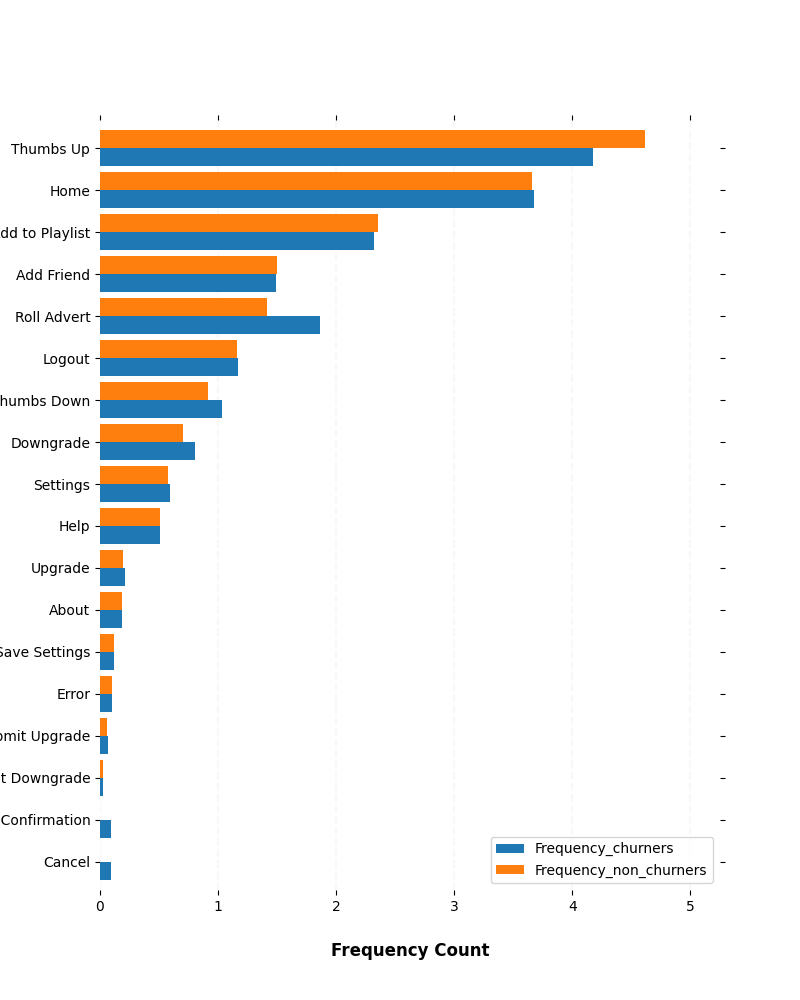

In [22]:
df_pd = churn_count_df.join(no_churn_count_df, "page", "outer").drop("count").fillna(0).toPandas()
df_pd = df_pd.sort_values(['Frequency_non_churners','Frequency_churners'])
ax = df_pd.plot.barh('page',  figsize=(8, 10), label=['#86bf91', '#48E4FA'], zorder=2, width=0.85)


# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Frequency Count", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Page", labelpad=20, weight='bold', size=12)


%matplot plt

#### Churn rate

In [23]:
df.groupby('Churn').agg((countDistinct('userId')/df.select('userId').dropDuplicates().count() * 100).alias('Churn rate')).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+
|Churn|        Churn rate|
+-----+------------------+
| true|22.458140683215873|
|false| 77.54185931678413|
+-----+------------------+

#### Timespan of log data

In [24]:
df.select(min('date'), max('date')).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-01|
+----------+----------+

#### Days since registration

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

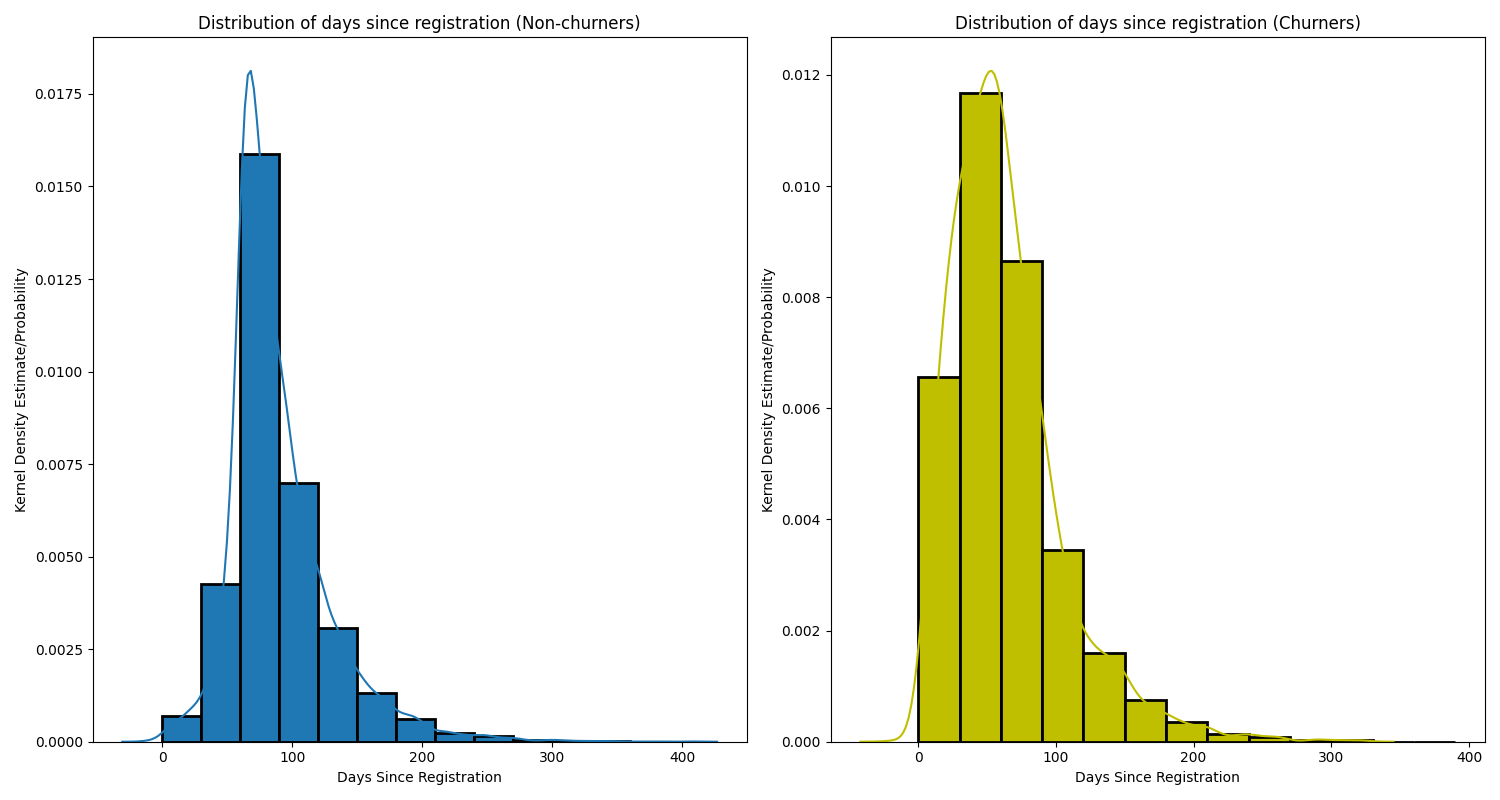

In [25]:
latest_session = df.groupBy('userId').agg(max('ts').alias("Latest_session")).sort('userId')
registration_date = df.select("userId","Churn", "registration").dropDuplicates().sort("userId")
    
registration_date = registration_date.join(latest_session,registration_date.userId == latest_session.userId) \
                                         .select(registration_date["userId"],'Churn', ((col("Latest_session")-col("registration"))/(1000*60*60*24)).alias("days_since_registration"))
    
plt.figure(figsize = (15,8))
plt.subplot(1, 2, 1)
days_since_registration_non_churners= registration_date.where('Churn == 0').select('days_since_registration').toPandas()
sb.distplot(days_since_registration_non_churners, np.arange(0, days_since_registration_non_churners.days_since_registration.max()+5, 30),hist_kws=dict(alpha=1,edgecolor="k", linewidth=2));
plt.xlabel('Days Since Registration')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of days since registration (Non-churners)')
plt.tight_layout()


plt.subplot(1, 2, 2)
days_since_registration_churners= registration_date.where('Churn == 1').select('days_since_registration').toPandas()
sb.distplot(days_since_registration_churners, np.arange(0, days_since_registration_non_churners.days_since_registration.max()+5, 30), color = 'y', hist_kws=dict(alpha=1,edgecolor="k", linewidth=2));
plt.xlabel('Days Since Registration')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of days since registration (Churners)')
plt.tight_layout()
%matplot plt

#### Number of Sessions (daily/monthly)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

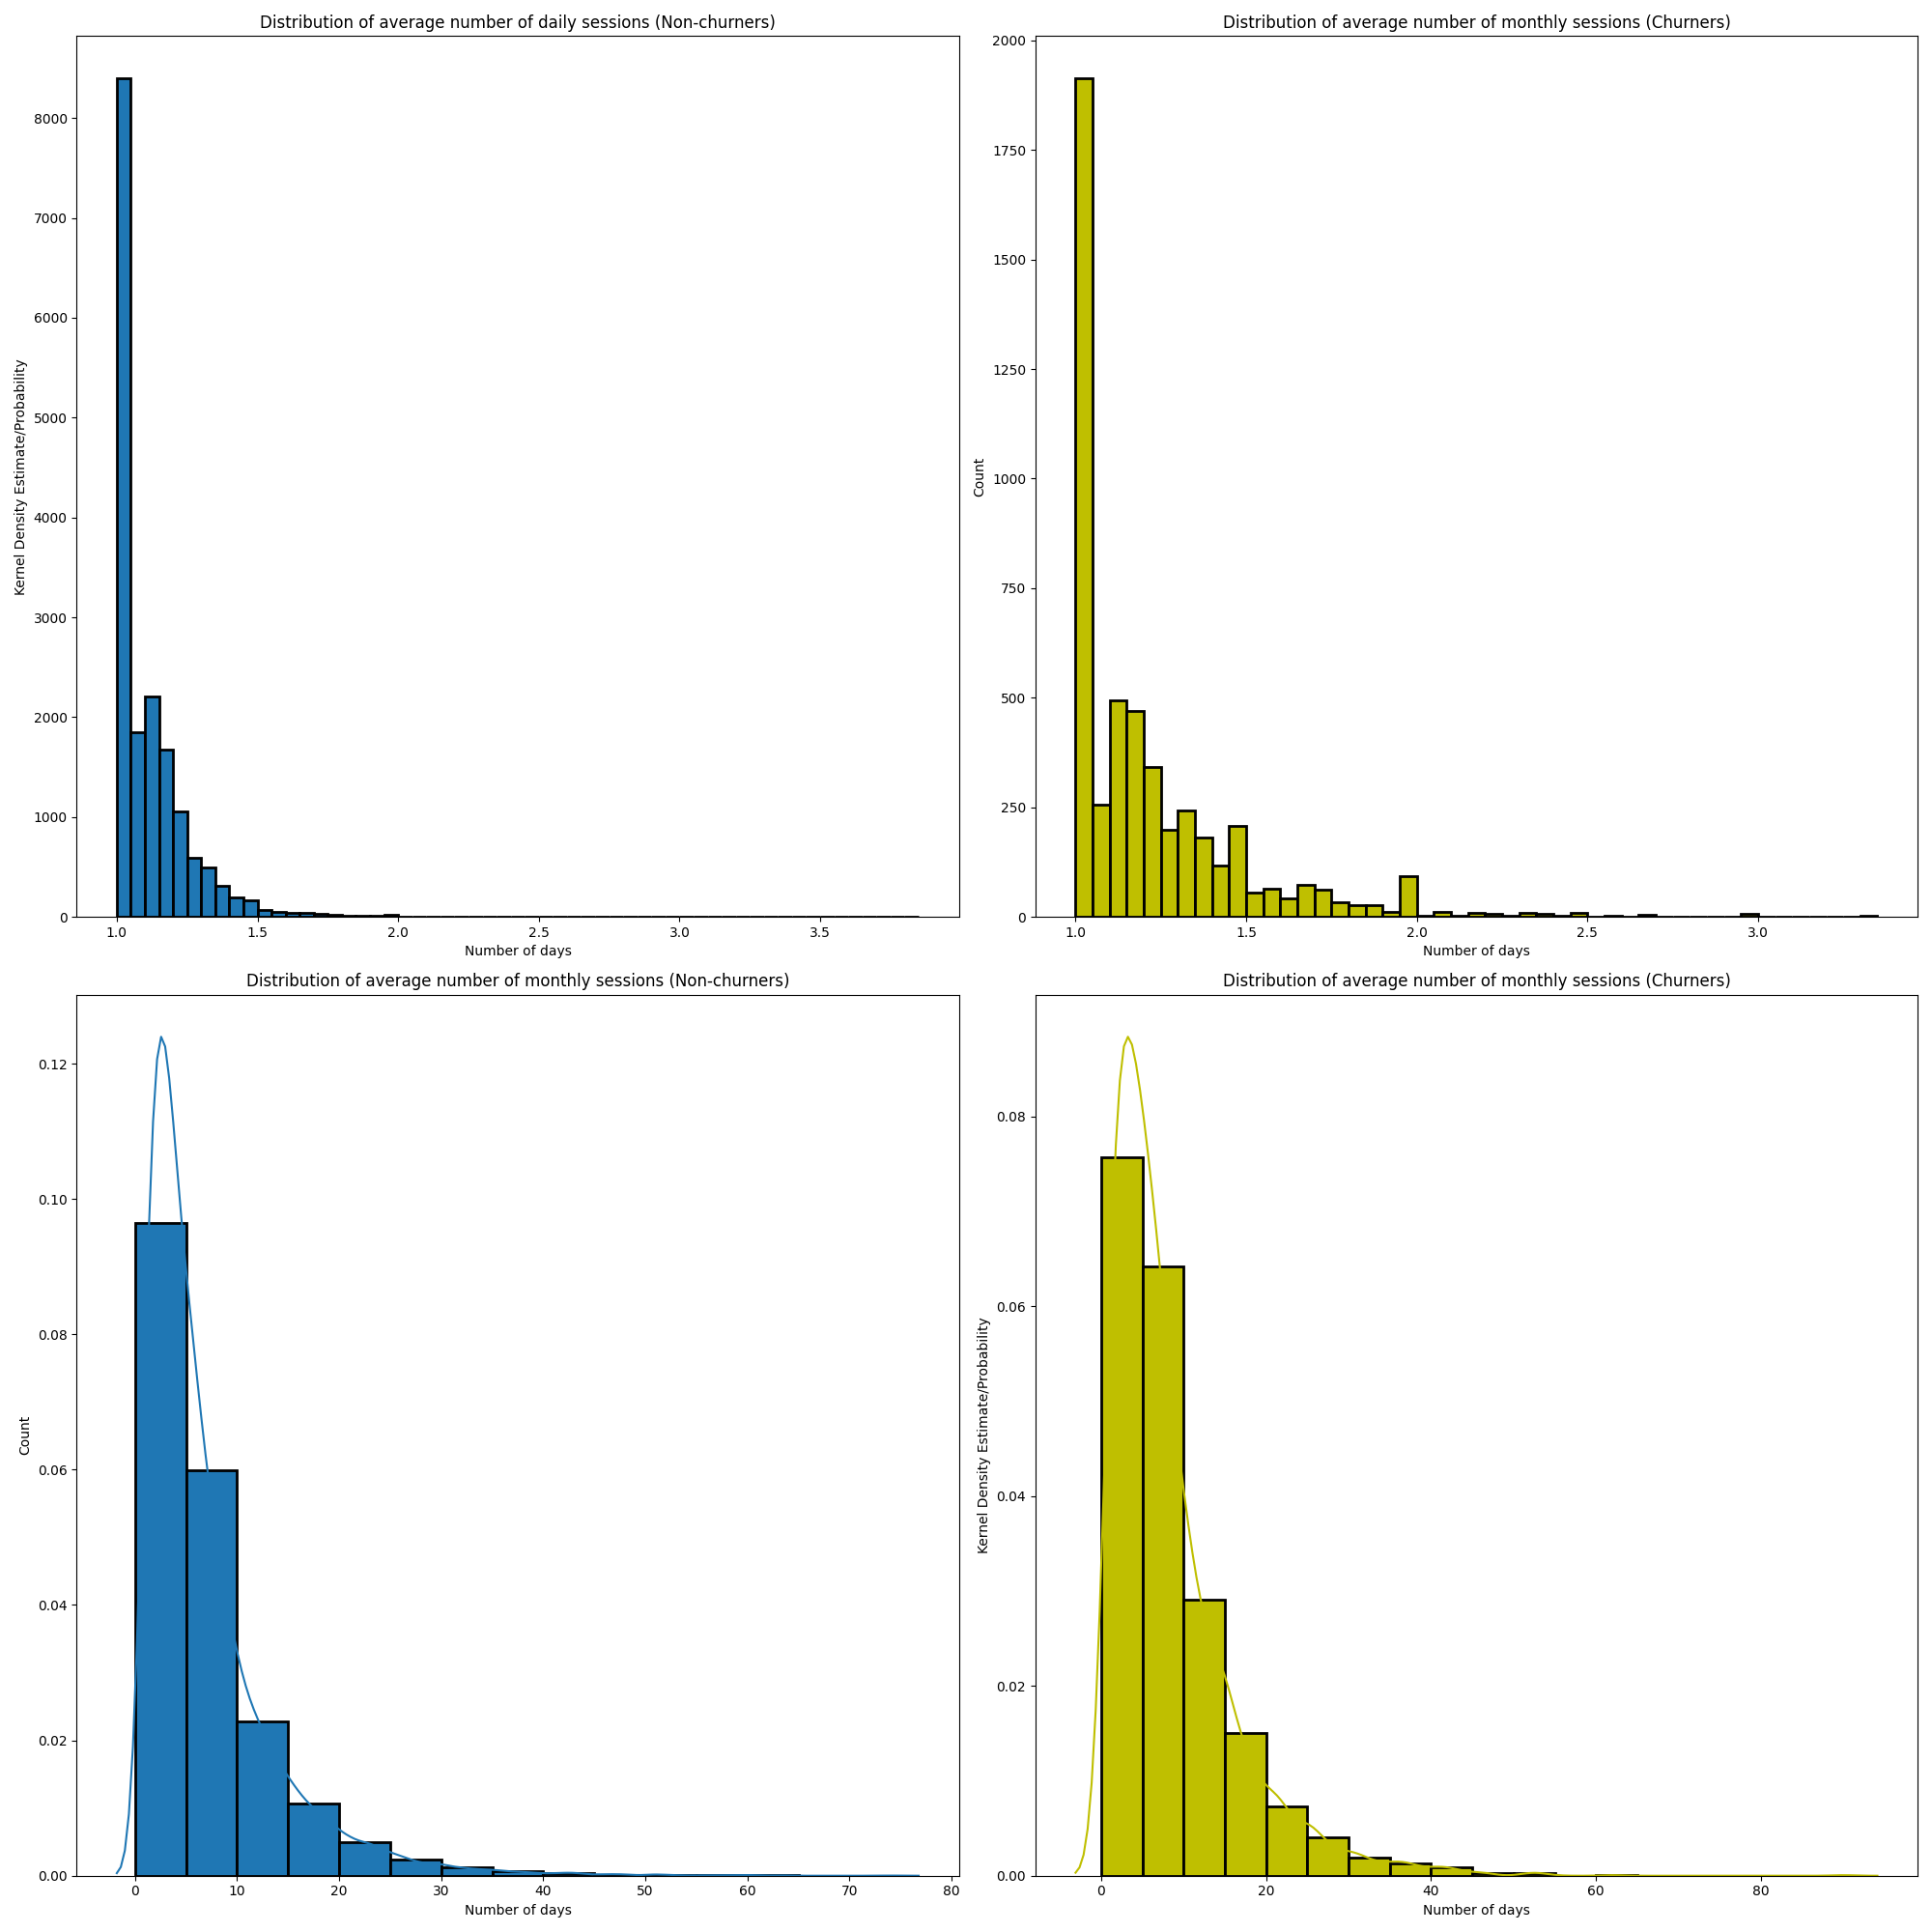

In [26]:
#Sessions
daily_sessions = df.groupby('userId','Churn', 'date') \
                      .agg(countDistinct('sessionId').alias('distinct_session_id')) \
                      .groupBy('userId', 'Churn').agg(avg('distinct_session_id').alias('daily_session_avg'))\
                      .sort('userId')
monthly_sessions = df.groupby('userId','Churn','month') \
                      .agg(countDistinct('sessionId').alias('distinct_session_id')) \
                      .groupBy('userId', 'Churn').agg(avg('distinct_session_id').alias('monthly_session_avg'))\
                      .sort('userId')
daily_sessions_churn = daily_sessions.where('Churn == 1').toPandas()
daily_sessions_no_churn = daily_sessions.where('Churn == 0').toPandas()
monthly_sessions_churn =  monthly_sessions.where('Churn == 1').toPandas()
monthly_sessions_no_churn =  monthly_sessions.where('Churn == 0').toPandas()


plt.figure(figsize = (20,20))
plt.subplot(2, 2, 1)
sb.distplot(daily_sessions_no_churn.daily_session_avg, np.arange(1, daily_sessions_no_churn.daily_session_avg.max()+1, .05),kde = False, hist_kws=dict(alpha=1,edgecolor="k", linewidth=2))
plt.xlabel('Number of days')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of average number of daily sessions (Non-churners)')
plt.tight_layout()


plt.subplot(2, 2, 2)
sb.distplot(daily_sessions_churn.daily_session_avg, np.arange(1, daily_sessions_no_churn.daily_session_avg.max()+.5, .05),kde = False, color= 'y', hist_kws=dict(alpha=1,edgecolor="k", linewidth=2))
plt.xlabel('Number of days')
plt.ylabel('Count')
plt.title('Distribution of average number of monthly sessions (Churners)')
plt.tight_layout()

plt.subplot(2, 2, 3)
sb.distplot(monthly_sessions_no_churn.monthly_session_avg, np.arange(0, monthly_sessions_no_churn.monthly_session_avg.max()+5, 5), hist_kws=dict(alpha=1,edgecolor="k", linewidth=2))
plt.xlabel('Number of days')
plt.ylabel('Count')
plt.title('Distribution of average number of monthly sessions (Non-churners)')
plt.tight_layout()

plt.subplot(2, 2, 4)
sb.distplot(monthly_sessions_churn.monthly_session_avg, np.arange(0, monthly_sessions_no_churn.monthly_session_avg.max()+5, 5),color = 'y', hist_kws=dict(alpha=1,edgecolor="k", linewidth=2))
plt.xlabel('Number of days')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of average number of monthly sessions (Churners)')
plt.tight_layout()
%matplot plt

#### Average Daily/Monthly Session Duration

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

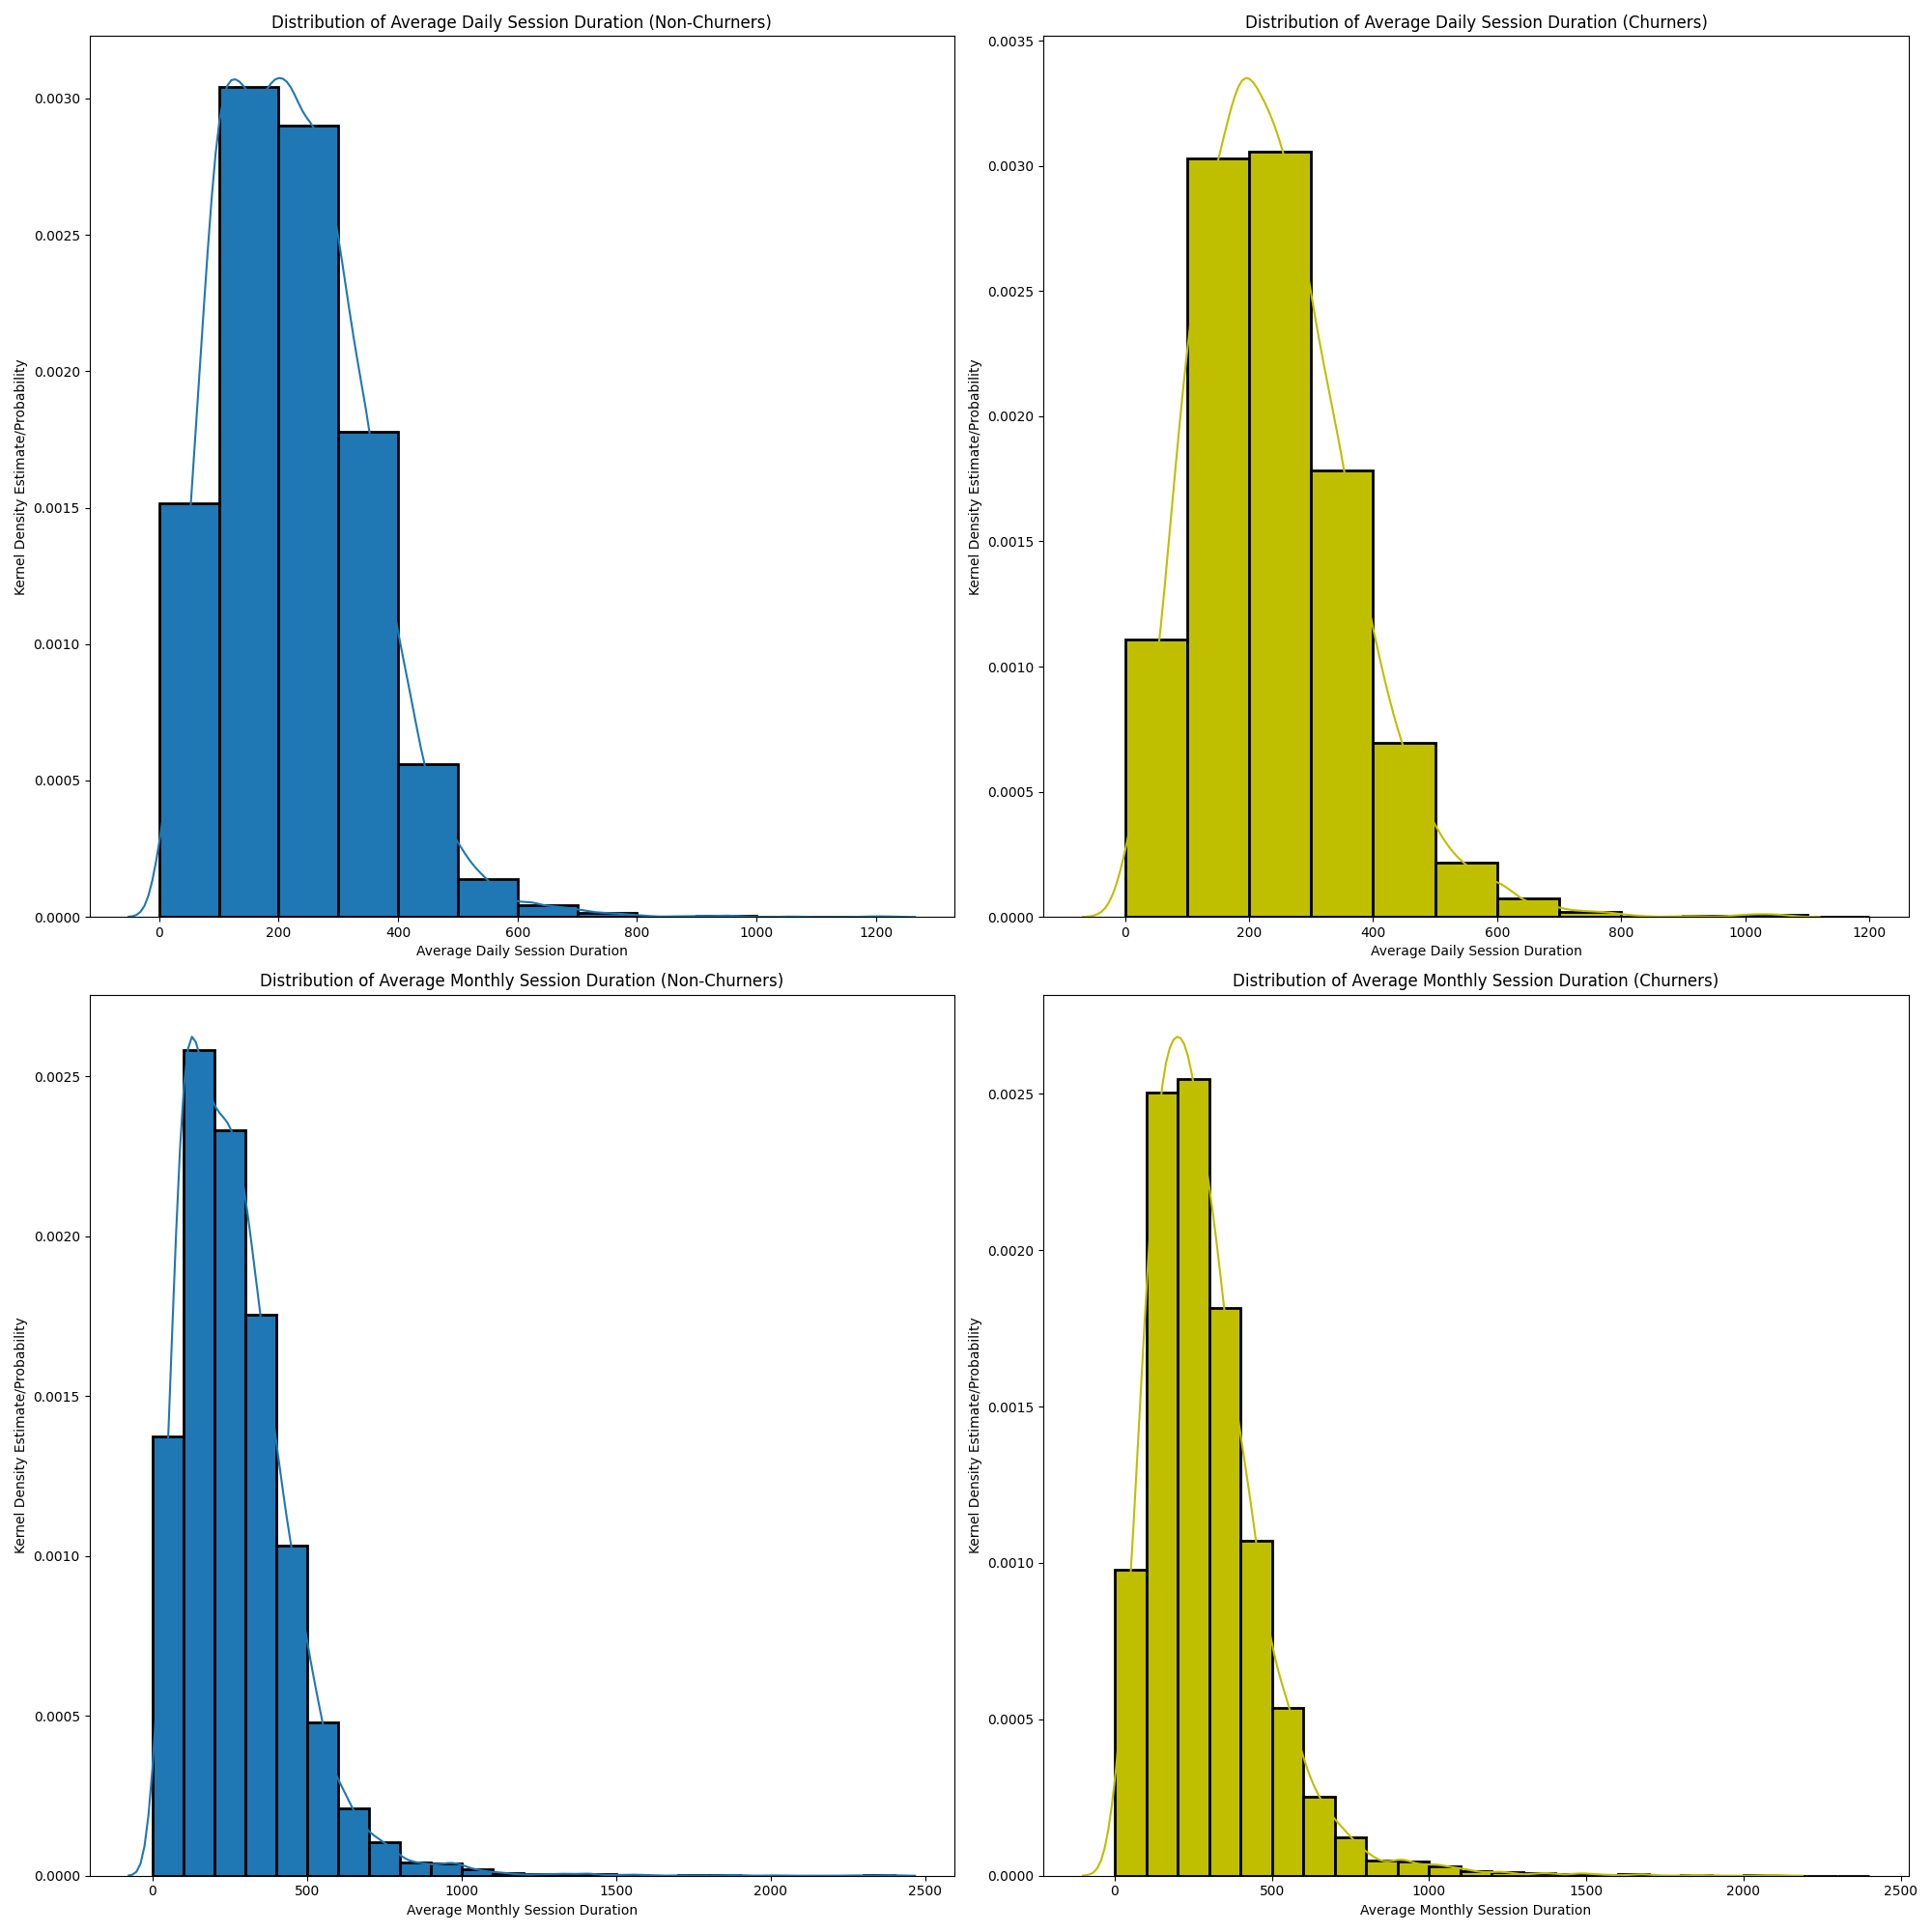

In [27]:
daily_session_duration = df.groupby('userId','date','Churn', 'sessionId') \
                                .agg(max('ts'), min('ts')) \
                                .withColumn('session_duration_min', (col('max(ts)') - col('min(ts)'))/(1000*60)) \
                                .groupby('userId','Churn', 'date').avg('session_duration_min') \
                                .groupby('userId', 'Churn').agg(avg('avg(session_duration_min)').alias('daily_session_duration_min_avg')) \
                                .sort('userId')
    
monthly_session_duration = df.groupby('userId','Churn','month', 'sessionId') \
                                .agg(max('ts'), min('ts')) \
                                .withColumn('session_duration_min', (col('max(ts)') - col('min(ts)'))/(1000*60)) \
                                .groupby('userId','Churn', 'month').avg('session_duration_min') \
                                .groupby('userId', 'Churn').agg(avg('avg(session_duration_min)').alias('monthly_session_duration_min_avg')) \
                                .sort('userId')
daily_sessions_duration_churn = daily_session_duration.where('Churn == 1').toPandas()
daily_sessions_duration_no_churn = daily_session_duration.where('Churn == 0').toPandas()
monthly_sessions_duration_churn =  monthly_session_duration.where('Churn == 1').toPandas()
monthly_sessions_duration_no_churn =  monthly_session_duration.where('Churn == 0').toPandas()

plt.figure(figsize = (20,20))
plt.subplot(2, 2, 1)
sb.distplot(daily_sessions_duration_no_churn.daily_session_duration_min_avg, np.arange(0, daily_sessions_duration_no_churn.daily_session_duration_min_avg.max()+10, 100), hist_kws=dict(alpha=1,edgecolor="k", linewidth=2))
plt.xlabel('Average Daily Session Duration')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of Average Daily Session Duration (Non-Churners)')
plt.tight_layout()


plt.subplot(2, 2, 2)
sb.distplot(daily_sessions_duration_churn.daily_session_duration_min_avg, np.arange(0, daily_sessions_duration_no_churn.daily_session_duration_min_avg.max()+10, 100), hist_kws=dict(alpha=1,edgecolor="k", linewidth=2), color = 'y')
plt.xlabel('Average Daily Session Duration')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of Average Daily Session Duration (Churners)')
plt.tight_layout()

plt.subplot(2, 2, 3)
sb.distplot(monthly_sessions_duration_no_churn.monthly_session_duration_min_avg, np.arange(0, monthly_sessions_duration_no_churn.monthly_session_duration_min_avg.max()+10, 100), hist_kws=dict(alpha=1,edgecolor="k", linewidth=2))
plt.xlabel('Average Monthly Session Duration')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of Average Monthly Session Duration (Non-Churners)')
plt.tight_layout()


plt.subplot(2, 2, 4)
sb.distplot(monthly_sessions_duration_churn.monthly_session_duration_min_avg, np.arange(0, monthly_sessions_duration_no_churn.monthly_session_duration_min_avg.max()+10, 100), hist_kws=dict(alpha=1,edgecolor="k", linewidth=2), color = 'y')
plt.xlabel('Average Monthly Session Duration')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of Average Monthly Session Duration (Churners)')
plt.tight_layout()
%matplot plt

#### Recency

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

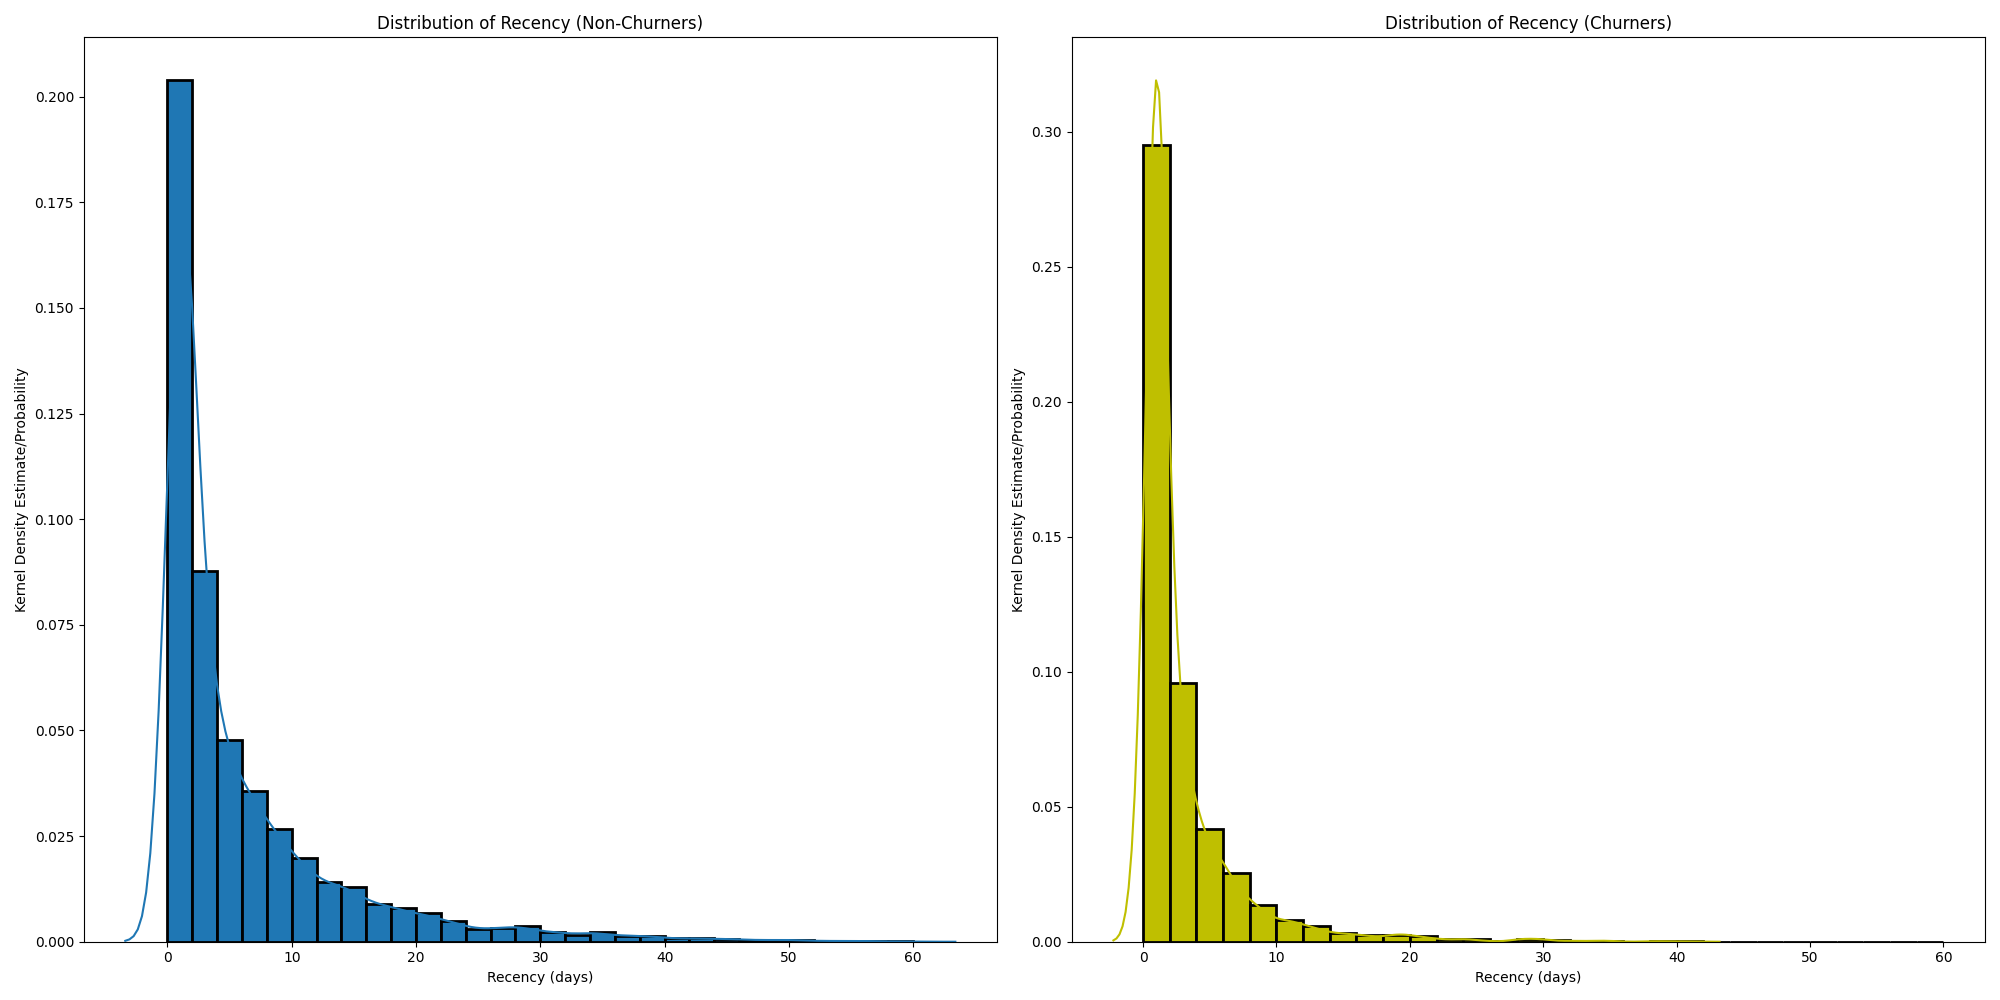

In [28]:
windowSpec  = Window.partitionBy("userId").orderBy(desc('date'))
recency_df  = df.groupby('userId', 'Churn', 'date').agg(count('page')).withColumn('Date_rank', rank().over(windowSpec)).where('Date_rank == 1 or Date_rank == 2') \
                  .groupby('userId', 'Churn').agg(max(col('date')).alias('Max_date'), min(col('date')).alias('Min_date')) \
                  .withColumn('Recency', datediff('Max_date','Min_date')) \
                  .select('userId','Churn', 'Recency') \
                  .sort('userId') 
recency_df_churn = recency_df.where('Churn == 1').toPandas()
recency_df_no_churn = recency_df.where('Churn == 0').toPandas()

plt.figure(figsize = (20,10))
plt.subplot(1, 2, 1)
sb.distplot(recency_df_no_churn.Recency, np.arange(0, recency_df_no_churn.Recency.max()+1, 2), hist_kws=dict(alpha=1,edgecolor="k", linewidth=2))
plt.xlabel('Recency (days)')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of Recency (Non-Churners)')
plt.tight_layout()


plt.subplot(1, 2, 2)
sb.distplot(recency_df_churn.Recency, np.arange(0, recency_df_no_churn.Recency.max()+1, 2), hist_kws=dict(alpha=1,edgecolor="k", linewidth=2), color = 'y')
plt.xlabel('Recency (days)')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of Recency (Churners)')
plt.tight_layout()
%matplot plt

#### Number of distinct Artists listened to

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

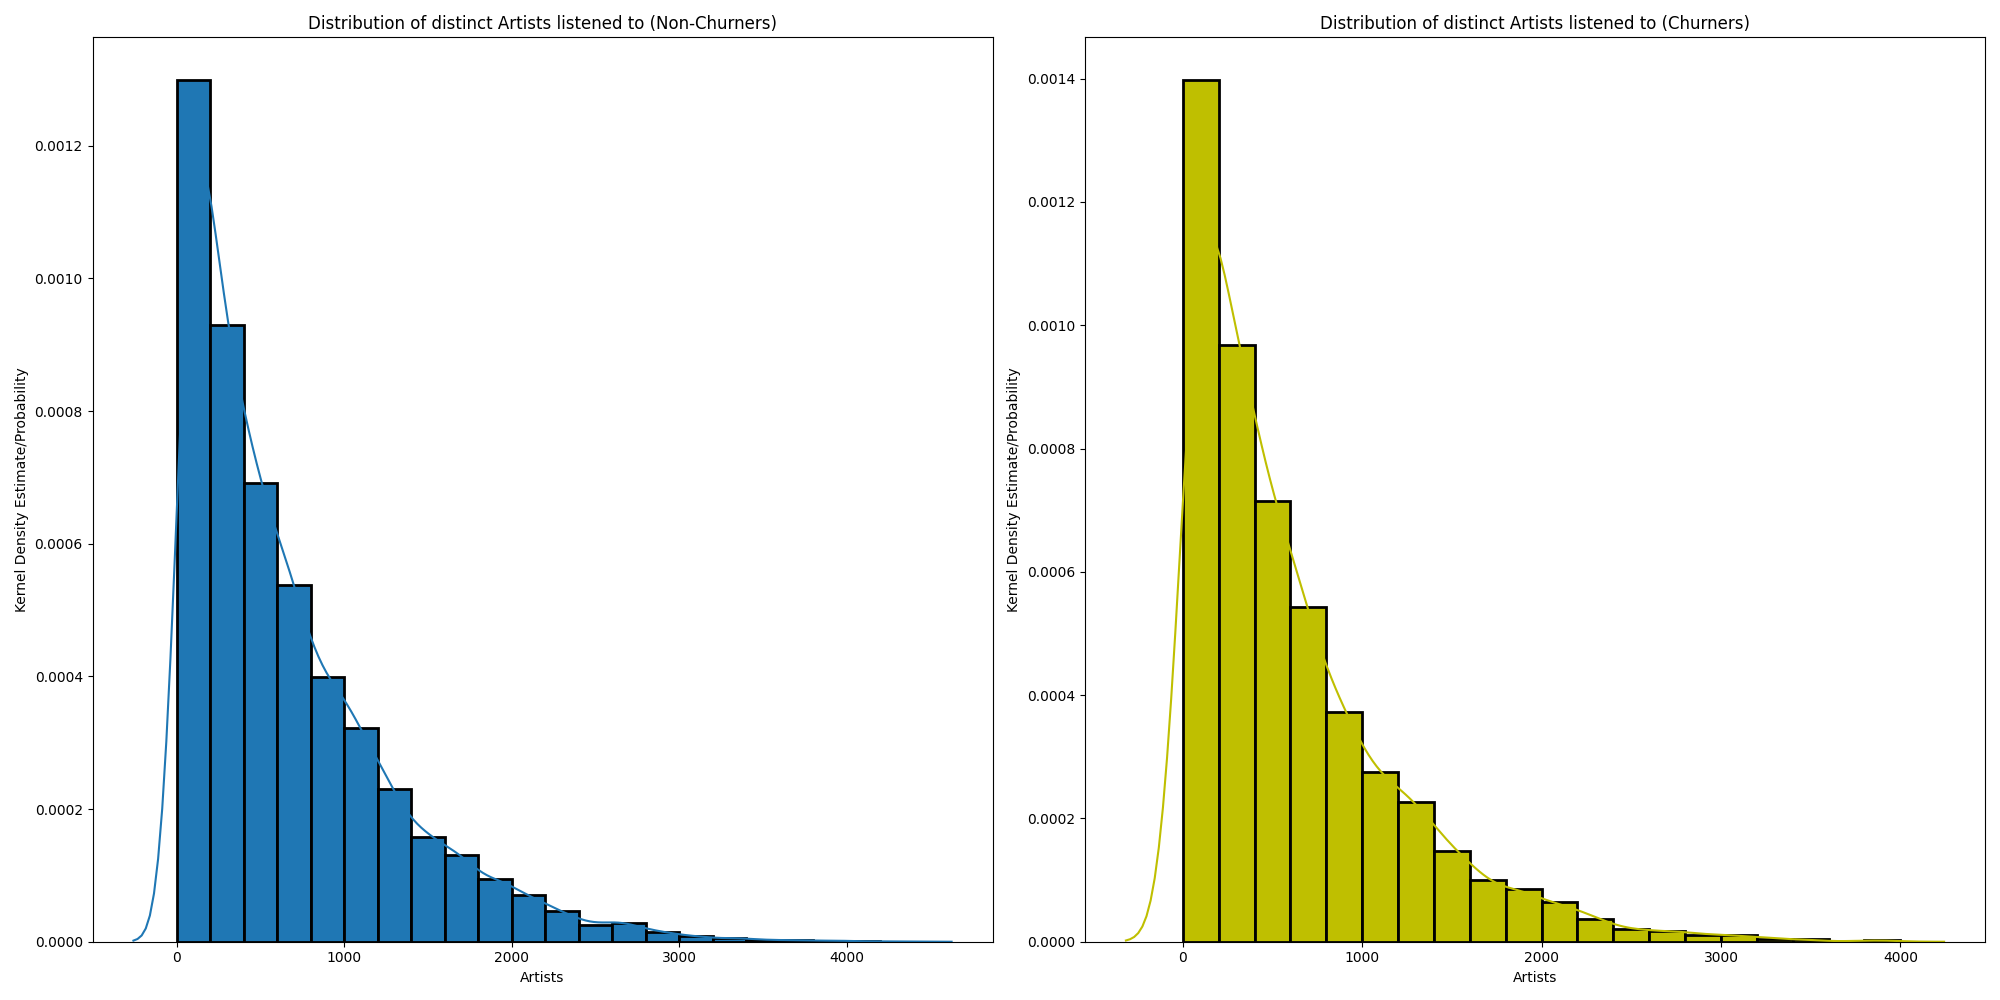

In [29]:
different_artists = df.groupby('userId', 'Churn').agg(countDistinct('Artist').alias('Distinct_artists')).sort('userId')

different_artists_churn = different_artists.where('Churn == 1').toPandas()
different_artists_no_churn = different_artists.where('Churn == 0').toPandas()  

plt.figure(figsize = (20,10))
plt.subplot(1, 2, 1)
sb.distplot(different_artists_no_churn.Distinct_artists, np.arange(0, different_artists_no_churn.Distinct_artists.max()+20, 200), hist_kws=dict(alpha=1,edgecolor="k", linewidth=2))
plt.xlabel('Artists')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of distinct Artists listened to (Non-Churners)')
plt.tight_layout()


plt.subplot(1, 2, 2)
sb.distplot(different_artists_churn.Distinct_artists, np.arange(0, different_artists_no_churn.Distinct_artists.max()+20, 200),hist_kws=dict(alpha=1,edgecolor="k", linewidth=2), color = 'y')
plt.xlabel('Artists')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of distinct Artists listened to (Churners)')
plt.tight_layout()
%matplot plt

#### Number of distinct Songs listened to

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

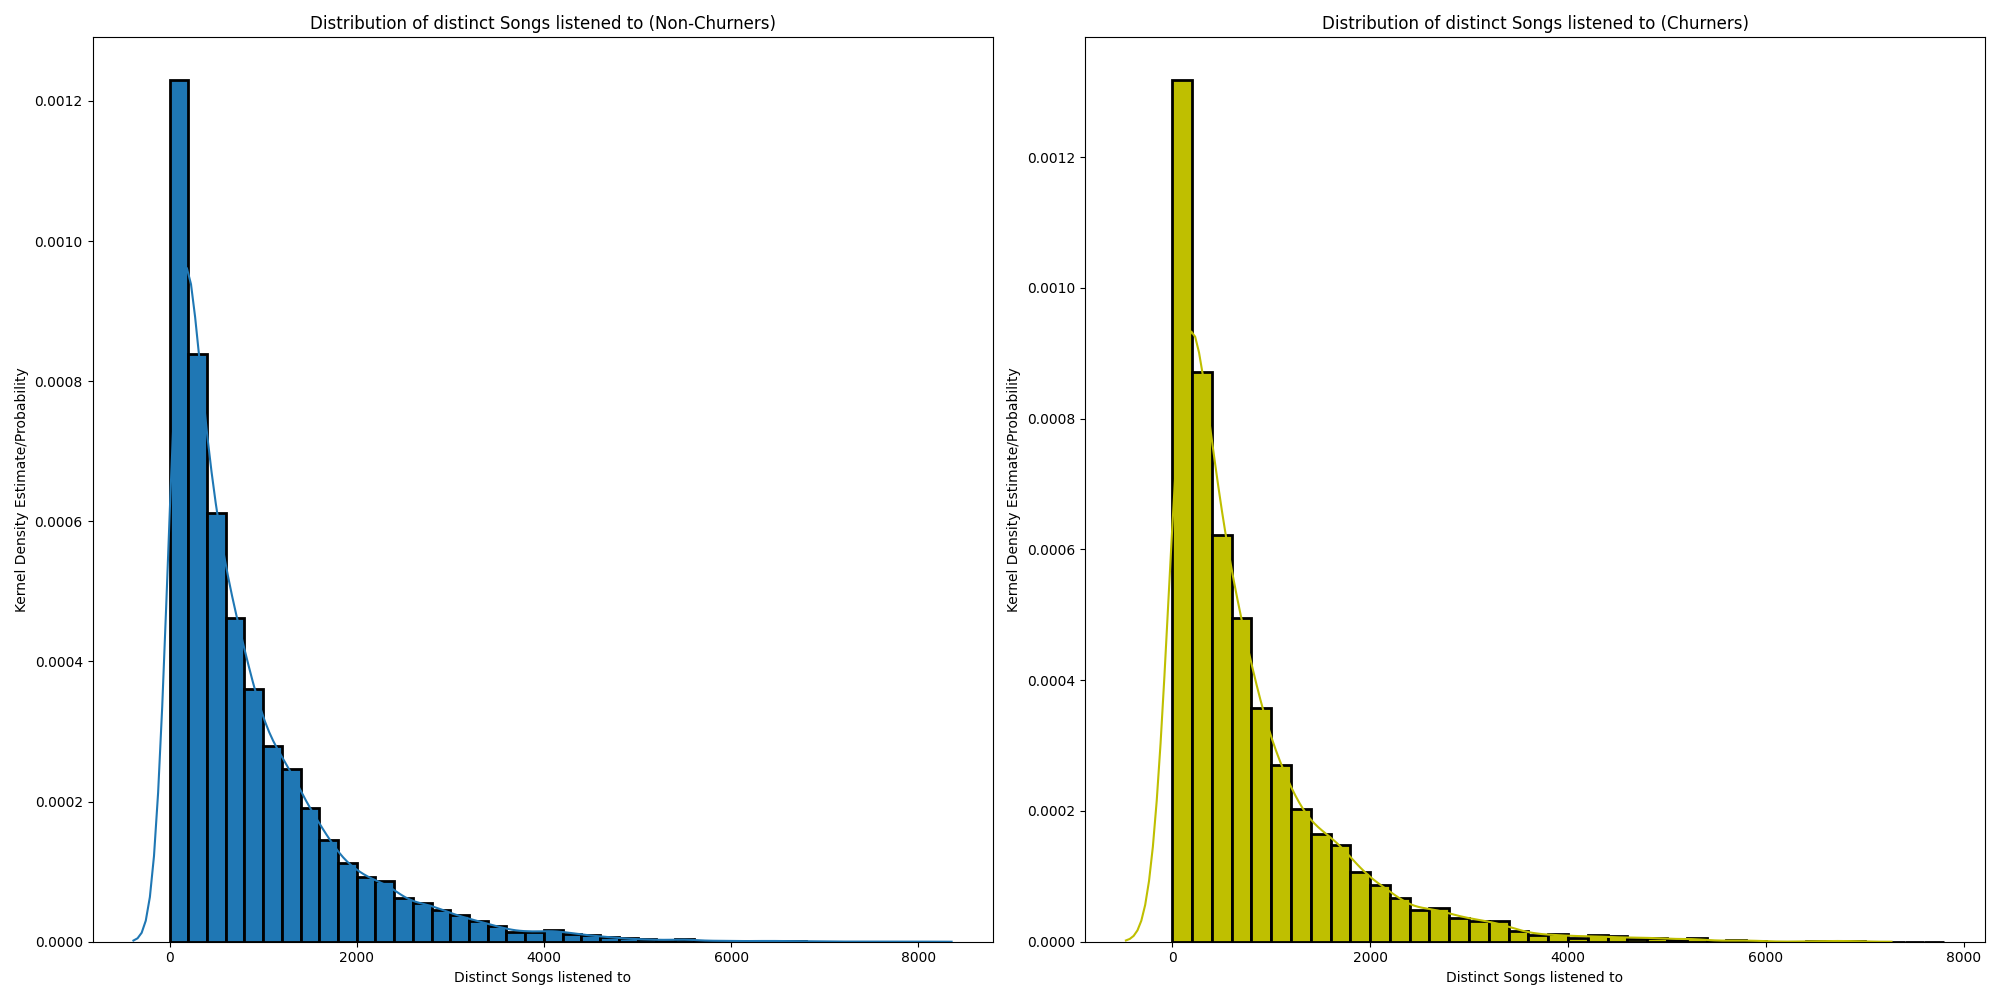

In [30]:
different_songs = df.groupby('userId', 'Churn').agg(countDistinct('song').alias('Distinct_songs')).sort('userId')

different_songs_churn = different_songs.where('Churn == 1').toPandas()
different_songs_no_churn = different_songs.where('Churn == 0').toPandas() 

plt.figure(figsize = (20,10))
plt.subplot(1, 2, 1)
sb.distplot(different_songs_no_churn.Distinct_songs, np.arange(0, different_songs_no_churn.Distinct_songs.max()+20, 200), hist_kws=dict(alpha=1,edgecolor="k", linewidth=2))
plt.xlabel('Distinct Songs listened to')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of distinct Songs listened to (Non-Churners)')
plt.tight_layout()


plt.subplot(1, 2, 2)
sb.distplot(different_songs_churn.Distinct_songs, np.arange(0, different_songs_no_churn.Distinct_songs.max()+20, 200),hist_kws=dict(alpha=1,edgecolor="k", linewidth=2), color = 'y')
plt.xlabel('Distinct Songs listened to')
plt.ylabel('Kernel Density Estimate/Probability')
plt.title('Distribution of distinct Songs listened to (Churners)')
plt.tight_layout()
%matplot plt

#### Churn by State

In [31]:
from matplotlib.ticker import PercentFormatter

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

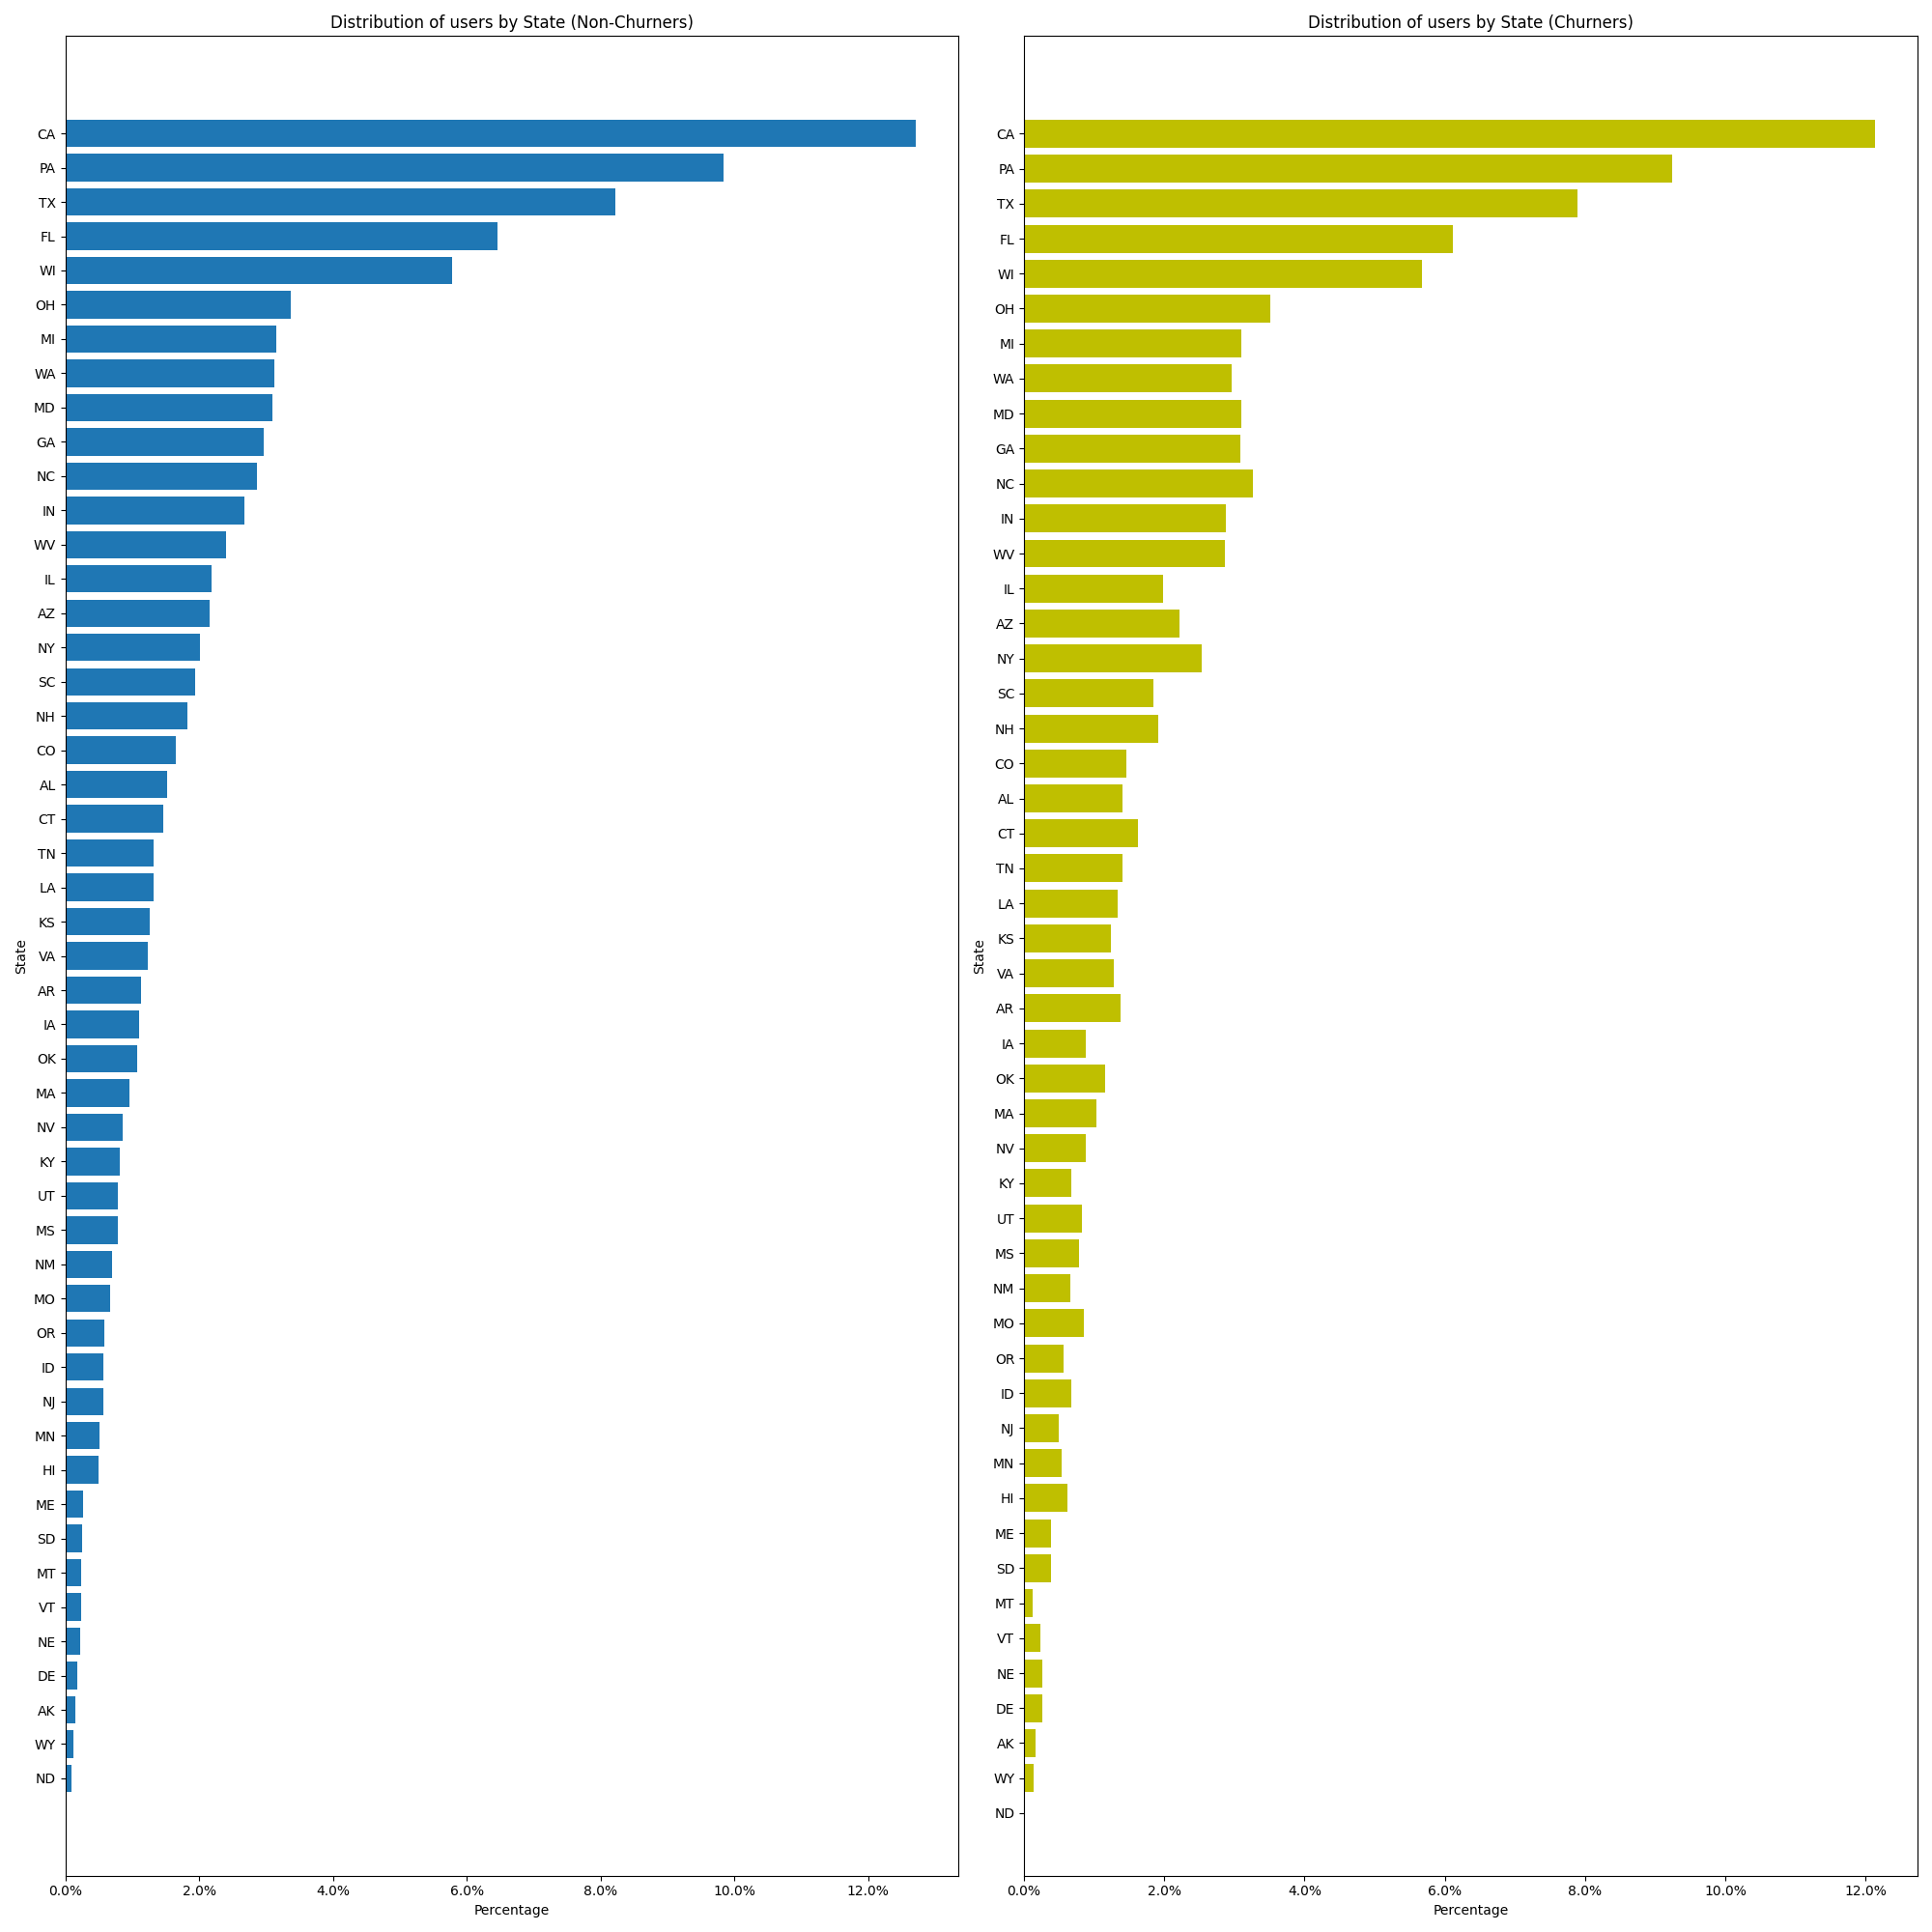

In [32]:
state_counts = df.groupby('state', 'Churn').agg(countDistinct('userId').alias('Users'))

state_counts_churn = state_counts.where('Churn == 1').sort('Users').toPandas()
state_counts_no_churn = state_counts.where('Churn == 0').sort('Users').toPandas()

state_counts_churn = state_counts_churn.set_index('state')
state_counts_churn = state_counts_churn.reindex(index=state_counts_no_churn['state'])
state_counts_churn = state_counts_churn.reset_index()

plt.figure(figsize = (20,20))
plt.subplot(1, 2, 1)
#plt.bar(x = state_counts_no_churn.state, height = state_counts_no_churn.Users)
plt.barh(y= state_counts_no_churn.state, width = state_counts_no_churn.Users /state_counts_no_churn.Users.sum())
plt.xlabel('Percentage')
plt.ylabel('State')
plt.title('Distribution of users by State (Non-Churners)')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()


plt.subplot(1, 2, 2)
#plt.bar(x = state_counts_churn.state, height = state_counts_churn.Users, color = 'y')
plt.barh(y= state_counts_churn.state, width = state_counts_churn.Users /state_counts_churn.Users.sum() , color = 'y')
plt.xlabel('Percentage')
plt.ylabel('State')
plt.title('Distribution of users by State (Churners)')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()
%matplot plt

#### Churn by Gender

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

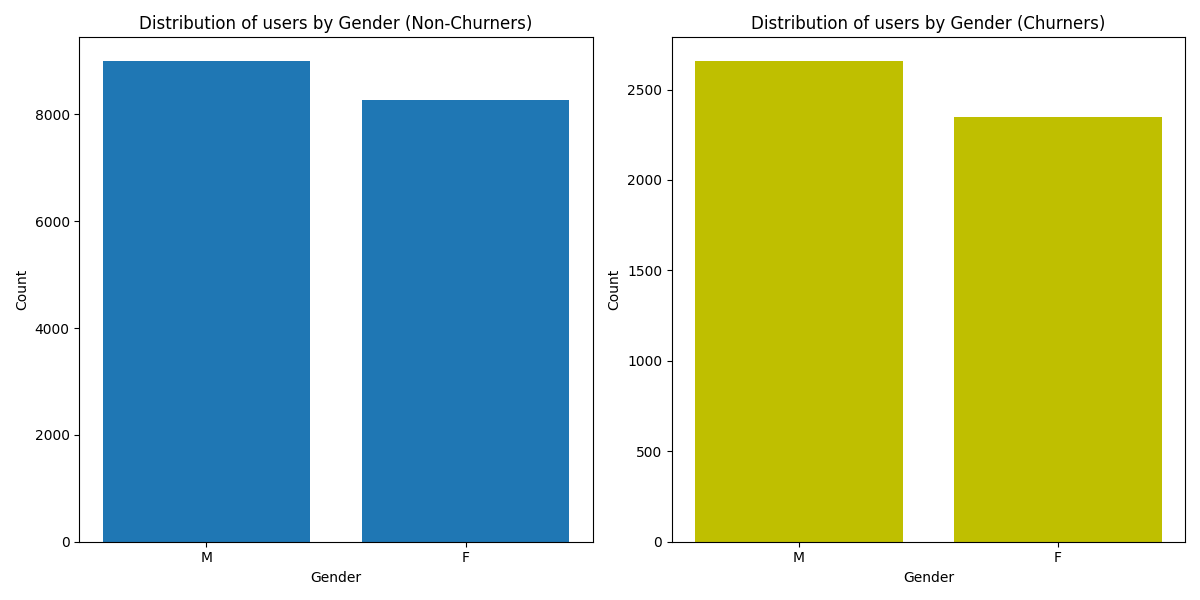

In [33]:
gender_counts = df.groupby('gender', 'Churn').agg(countDistinct('userId').alias('Users'))

gender_counts_churn = gender_counts.where('Churn == 1').toPandas()
gender_counts_no_churn = gender_counts.where('Churn == 0').toPandas()

plt.figure(figsize = (12,6))
plt.subplot(1, 2, 1)
plt.bar(x = gender_counts_no_churn.gender, height = gender_counts_no_churn.Users)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of users by Gender (Non-Churners)')

plt.tight_layout()


plt.subplot(1, 2, 2)
plt.bar(x = gender_counts_churn.gender, height = gender_counts_churn.Users, color = 'y')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of users by Gender (Churners)')
plt.tight_layout()
%matplot plt


## Feature Engineering <a id='features'></a>

Based on the above data exploration, I will be looking at the following features which seem interesting:

- Number of days since registration 
- Recent level
- Number of sessions
- Session duration
- Recency
- Moving average latest ession
- Different rtists listened to
- Different songs listened to
- Visits of different pages
- Gender
- State


#### Number of Days Since Registration

This is defined as the number of days between registration and last interaction (latest session)

In [34]:
def days_since_registration(df):
    '''
    Calculates number of days between registration and the last interaction
    
    param: spark dataframe
    Return: df with registration date of user
    '''
    latest_session = df.groupBy('userId').agg(max('ts').alias("Latest_session")).sort('userId')
    registration_date = df.select("userId", "registration").dropDuplicates().sort("userId")
    
    registration_date = registration_date.join(latest_session,registration_date.userId == latest_session.userId) \
                                         .select(registration_date["userId"], ((col("Latest_session")-col("registration"))/(1000*60*60*24)).alias("days_since_registration"))
    
    return registration_date

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Recent Level

This is defined as the latest level of the user (paid/free plan)

In [35]:
def recent_level(df):
    '''
    Finds the latest level of each user
    param df: spark DataFrame
    Return: df with latest level assigned to each user
    '''
    recent_level = df.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('recent_level')).withColumn('recent_level', when(col('recent_level') == 'free', 0).otherwise(1))
    
    return recent_level

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Number of Sessions (daily and montly)

This is defined as the average number of daily/monthly sessions

In [36]:
def number_of_sessions(df):
    '''
    Calculates the number of daily and monthly sessions per user
    
    param: Spark dataframe
    Return: df with daily and monthly sessions per user
    
    '''
    daily_sessions = df.groupby('userId','date') \
                      .agg(countDistinct('sessionId').alias('distinct_session_id')) \
                      .groupBy('userId').agg(avg('distinct_session_id').alias('daily_session_avg'))\
                      .sort('userId')
    monthly_sessions = df.groupby('userId','month') \
                      .agg(countDistinct('sessionId').alias('distinct_session_id')) \
                      .groupBy('userId').agg(avg('distinct_session_id').alias('monthly_session_avg'))\
                      .sort('userId')
    return daily_sessions.join(monthly_sessions, on='userId')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Session duration

This is defined as the average daily/monthly session duration in minutes

In [37]:
def session_duration(df):
    '''
    Calculates daily and monthly average of session duration
    param:spark DataFrame
    Return: daily and monthly aggregates DataFrame
    '''
    daily_session_duration = df.groupby('userId','date', 'sessionId') \
                                .agg(max('ts'), min('ts')) \
                                .withColumn('session_duration_min', (col('max(ts)') - col('min(ts)'))/(1000*60)) \
                                .groupby('userId', 'date').avg('session_duration_min') \
                                .groupby('userId').agg(avg('avg(session_duration_min)').alias('daily_session_duration_min_avg')) \
                                .sort('userId')
    
    monthly_session_duration = df.groupby('userId','month', 'sessionId') \
                                .agg(max('ts'), min('ts')) \
                                .withColumn('session_duration_min', (col('max(ts)') - col('min(ts)'))/(1000*60)) \
                                .groupby('userId', 'month').avg('session_duration_min') \
                                .groupby('userId').agg(avg('avg(session_duration_min)').alias('monthly_session_duration_min_avg')) \
                                .sort('userId')
    
    
    return daily_session_duration.join(monthly_session_duration, on='userId')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

####  Recency

This is defined as the amount of days between the last session and the session before that.

In [38]:
def recency(df):
    '''
    Calculates number of days between last session and the session before that.
    
    param: Spark dataframe
    Return: df with recency in days for user
    
    '''
    
    windowSpec  = Window.partitionBy("userId").orderBy(desc('date'))
    recency_df  = df.groupby('userId', 'date').agg(count('page')).withColumn('Date_rank', rank().over(windowSpec)).where('Date_rank == 1 or Date_rank == 2') \
                  .groupby('userId').agg(max(col('date')).alias('Max_date'), min(col('date')).alias('Min_date')) \
                  .withColumn('Recency', datediff('Max_date','Min_date')) \
                  .select('userId', 'Recency') \
                  .sort('userId') 
    return recency_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Different Artists

This is defined as the distinct number of artists listened to.

In [39]:
def different_artists(df):
    '''
    Calculates the number of distinct artists listened to by user.
    
    param: Spark dataframe
    Return: df with number of distinct artists listened to.
    
    '''
    different_artists = df.groupby('userId').agg(countDistinct('Artist').alias('Distinct_artists')).sort('userId')
    return different_artists

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Different Songs

This is defined as the distinct number of artists listened to.

In [40]:
def different_songs(df):
    '''
    Calculates the number of distinct songs listened to by user.
    
    param: Spark dataframe
    Return: df with number of distinct songs listened to.
    
    '''
    different_songs = df.groupby('userId').agg(countDistinct('song').alias('Distinct_songs')).sort('userId')
    return different_songs

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Page visits

This is defined as the number of visits per page

In [41]:
def page_visits(df):
    '''
    Calculates the number of visist of each page per user.
    
    param: Spark dataframe
    Return: pivoted df with pages as columns and values as total visits.
    '''
    page_visits_df = df.groupby('userId').pivot('page').agg(count('page')).sort('userId').na.fill(0)
    page_visits_df = page_visits_df.drop('Cancellation Confirmation', 'Cancel')
    return page_visits_df
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Data Preparation

With the following function we prepare the data for modelling. It merges all of the above data into a single dataframe. We inspect the schema and have a look at the data before going on to the modelling phase.

A unique dataframe is created on user level instead log level, with all the features combined. All of the above feature engineering functions are applied to this dataframe.

In [42]:
def add_features(df):
    '''
    Creates a unique df on user level and applies all feature engineering functions from above on the data.
    
    param: Spark dataframe
    Return: df on user level with features added.
    '''
    #Create unique user dataframe
    unique_df = df.select('userId', 'Churn', 'gender', 'state').dropDuplicates(['userId']).sort('userId')
    # Apply all functions
    page_visits_df = page_visits(df)
    different_songs_df = different_songs(df)
    different_artists_df = different_artists(df)
    recency_df = recency(df)
    session_duration_df = session_duration(df)
    number_of_sessions_df = number_of_sessions(df)
    recent_level_df = recent_level(df)
    days_since_registration_df = days_since_registration(df)
    
    
    unique_df = unique_df.join(page_visits_df, on='userId', how = 'left')
    unique_df = unique_df.join(different_songs_df, on='userId', how = 'left')  
    unique_df = unique_df.join(different_artists_df, on='userId', how = 'left')    
    unique_df = unique_df.join(recency_df, on='userId', how = 'left')
    unique_df = unique_df.join(session_duration_df, on='userId', how = 'left')
    unique_df = unique_df.join(number_of_sessions_df, on='userId', how = 'left')
    unique_df = unique_df.join(recent_level_df, on='userId', how = 'left')
    unique_df = unique_df.join(days_since_registration_df, on='userId', how = 'left')    
        
    return unique_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
#Add features
df = add_features(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
#Inspect df
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(userId='1001393', Churn=False, gender='M', state='OH', About=1, Add Friend=11, Add to Playlist=18, Downgrade=5, Error=1, Help=6, Home=27, Logout=11, NextSong=494, Roll Advert=0, Save Settings=4, Settings=8, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=43, Upgrade=1, Distinct_songs=475, Distinct_artists=425, Recency=17, daily_session_duration_min_avg=272.57708333333335, monthly_session_duration_min_avg=329.9216666666667, daily_session_avg=1.0, monthly_session_avg=3.5, recent_level=1, days_since_registration=59.88304398148148)

In [45]:
#clear cache so that we don't have unnecessary items clogging up memory before modelling
spark.catalog.clearCache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Modelling <a id='modelling'></a>


In the modelling phase, we first add our churn label, identify categorical and numerical features, create a train test split and create a machine learning pipeline that consists of transforming the features, a parameter grid and 3-fold cross validation.

The following models are run:

- Logistic Regression
- Random Forest
- Gradient Boosted Trees

We evaluate the above models on the test set using the following metrics:
- The accuracy
- The F1 score
- The areaUnderROC

In [46]:
#Add label column
df = df.withColumnRenamed('Churn', 'label')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
df = df.withColumn('label', col('label').cast(IntegerType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Train Test Split

In [48]:
#Categorical features
cat_features = ['gender', 'state']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
#Numeric features
num_features = df.drop('gender','state', 'usage_moving_avg',  'label', 'recent_level', 'userId').columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
#Train test split
train, test = df.randomSplit([.8,.2],seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
#Transforming our features
#Index our string columns
#Apply one hot encoding to them
#Assemble all numerical features into a numeric feature vector
#Scale the numeric features
#Assemble all features into a feature vector

indexer = StringIndexer(inputCols = cat_features, outputCols =['gender_index', 'state_index']) 
encoder = OneHotEncoder(inputCols = ['gender_index', 'state_index'], outputCols = ['gender_code', 'state_code'])
assembler_num = VectorAssembler(inputCols= num_features, outputCol="num_features")
scaler = MinMaxScaler(inputCol= "num_features" , outputCol="normalized_num_features")
assembler = VectorAssembler(inputCols= ['gender_code', 'state_code','recent_level', 'normalized_num_features'], outputCol="features")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Logistic Regression

In [52]:
#Remove main df from memory to speed up performance of training the models
df.unpersist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[userId: string, label: int, gender: string, state: string, About: bigint, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint, Distinct_songs: bigint, Distinct_artists: bigint, Recency: int, daily_session_duration_min_avg: double, monthly_session_duration_min_avg: double, daily_session_avg: double, monthly_session_avg: double, recent_level: int, days_since_registration: double]

In [53]:
lr =  LogisticRegression(labelCol = 'label', featuresCol = 'features', maxIter=10, regParam=0.0, elasticNetParam=0)

lr_pipeline = Pipeline(stages=[indexer,encoder, assembler_num,scaler,assembler, lr])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()


crossval_lr = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
#Fit model
lr_model = crossval_lr.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-55:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 2171



In [56]:
#Apply model on test set
results_lr = lr_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
def evaluate_model(model, results):
    """
    Runs output evaluator on the prediction results and computes average F1 score over folds, Accuracy, F1 score and AUC.
    param model: Model
    param results: df with prediction results
    return None
    """
    avg_metrics = model.avgMetrics
    print('The average metrics on the test set are {}'.format(avg_metrics))
    
    accuracy_model = results.where(col('prediction')==col('label')).count() / results.count()
    print('The accuracy on the test set is {:.2%}'.format(accuracy_model))
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    print('The F1 score on the test set is {:.2%}'.format(f1_score)) 
    
    auc_evaluator = BinaryClassificationEvaluator()
    metric_value = auc_evaluator.evaluate(results, {auc_evaluator.metricName: "areaUnderROC"})
    print('The areaUnderROC on the test set is {:.2%}'.format(metric_value))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
evaluate_model(lr_model, results_lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The average metrics on the test set are [0.8075110206001792, 0.7938784924964406]
The accuracy on the test set is 83.31%
The F1 score on the test set is 80.60%
The areaUnderROC on the test set is 81.03%

In [178]:
lr_model.bestModel.stages[-1].getRegParam()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.0

#### Random Forest Classifier

In [59]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rf_pipeline = Pipeline(stages=[indexer,encoder, assembler_num,scaler,assembler, rf])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [10, 20]) \
    .build()   
    


crossval_rf = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
#Fit model
rf_model = crossval_rf.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-61:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 5225



In [62]:
#Apply model on test set
results_rf = rf_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
evaluate_model(rf_model, results_rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-63:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 15267



The average metrics on the test set are [0.8205824077232452, 0.821422154708747, 0.8402318948831566, 0.842821221976777]
The accuracy on the test set is 94.15%
The F1 score on the test set is 83.59%
The areaUnderROC on the test set is 84.65%

In [165]:
rf_model.bestModel.stages[-1].getNumTrees

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

20

In [167]:
rf_model.bestModel.stages[-1].getMaxDepth()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

20

#### Gradient Boosted Trees

In [64]:
gbt = GBTClassifier(labelCol="label", featuresCol="features")
gbt_pipeline = Pipeline(stages=[indexer,encoder, assembler_num,scaler,assembler, gbt])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [5, 10]) \
    .addGrid(gbt.maxDepth, [5, 10,20]) \
    .build()   
    


crossval_gbt = CrossValidator(estimator=gbt_pipeline,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
#Fit model
gbt_model = crossval_gbt.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-66:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 16284



In [67]:
#Apply model on test set
results_gbt = gbt_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
evaluate_model(gbt_model, results_gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-68:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 66797



The average metrics on the test set are [0.8162733583228811, 0.8006077887330345, 0.7450127493019181, 0.8268864148226613, 0.8162210103254126, 0.754900452080332]
The accuracy on the test set is 85.49%
The F1 score on the test set is 82.73%
The areaUnderROC on the test set is 82.61%

In [112]:
gbt_model.bestModel.stages[-1].getMaxIter()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10

In [113]:
gbt_model.bestModel.stages[-1].getMaxDepth()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

5

## Results <a id='results'></a>

As can be concluded from above, the Random Forest model seems to perform the best of all three models, with the following results:

- The accuracy on the test set is **94.49%**
- The F1 score on the test set is **83.74%**
- The areaUnderROC on the test set is **84.44%**

The Random Forest model was able to accurately predict 94,49% of cases, with the Recall and Precision (particularly of importance in imbalanced class prediction problems) also quite high. 

Feel free to contact me for any questions on jovanglig@hotmail.com. I would be happy to answer them.

Have a look on my github for other interesting projects: https://github.com/jovanglig/